In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from random import randint
import random

In [2]:
img_height = 1216
img_width = 608
min_noise = 50
max_noise = 150
min_radius = 1
max_radius = 10
num_channels = 4
img_shape = (img_height, img_width, num_channels)
num_classes = 1

In [3]:
img_shape

(1216, 608, 4)

In [4]:
class draw_circle_by_opencv:
    def draw_circle_on_image(img_height, img_width, min_noise, max_noise, min_radius, max_radius):
        image = np.zeros([img_height, img_width,4])
        background_color = random.uniform(0.5,1)
        image[:,:] = (background_color,background_color ,background_color , 1)
        
        for _ in range(min_noise, max_noise):
            radius = randint(min_radius, max_radius)
            x = randint(0, img_width)
            y = randint(0, img_height)
            cv2.circle(image,(x, y), radius, (0,0,0,1), -1) # -1 means fill up
        
        return(image)

In [5]:
#from skimage.io import imread
def get_input():
    
    img = draw_circle_by_opencv.draw_circle_on_image(img_height, img_width, min_noise, max_noise, min_radius, max_radius) 
    
    return(img)

In [6]:
def get_output(input_image):
    
    input_image[input_image[:,:] == 0] = 1
    input_image[input_image[:,:] != 1] = 0    
    
    return(input_image)

In [7]:
# def preprocess_input(image):
    
#     --- Rescale Image
#     --- Rotate Image
#     --- Resize Image
#     --- Flip Image
#     --- PCA etc.
    
#     return(image)

In [8]:
def image_generator(batch_size = 4):
    
    while True:
        # Select files (paths/indices) for the batch

        batch_input = []
        batch_output = [] 
          
        # Read in each input, perform preprocessing and get labels
        for _ in range(batch_size):
            input = get_input()
            output = get_output(input)
            
            #input = preprocess_input(image=input)
            batch_input.append(input)
            batch_output.append(output)
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

construct UNet

In [9]:
from keras import regularizers
from keras.layers import BatchNormalization as BatchNorm
from keras.models import Model, load_model
from keras.layers import Input, Reshape, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import layers

Using TensorFlow backend.


In [10]:
def downsampling(x, level, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, pool_size = 2, pool_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=conv_strides, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'downsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNorm(name = 'downsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'downsampling_' + str(level) + '_activation_' + str(i))(x)
    skip = x
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    return x, skip

def bottleneck_dilated(x, filters, kernel_size, num_convs = 6, activation = 'relu', batch_norm = False, last_activation = False, regularizer = None, regularizer_param = 0.001):
#     assert num_convs == len(conv_strides)
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    skips = []
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, dilation_rate = 2 ** i, activation='relu', padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'bottleneck_skip_' + str(i))(x)
        skips.append(x)
    x = layers.add(skips)
    if last_activation:
        x = Activation('relu')(x)
    return x
    
def bottleneck(x, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, pool_size = 2, pool_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'bottleneck_' + str(i))(x)
        if batch_norm:
            x = BatchNorm()(x)
        x = Activation(activation)(x)
    return x

def upsampling(x, level, skip, filters, kernel_size, num_convs, conv_strides=1, activation = 'relu', batch_norm = False, conv_transpose = True, upsampling_size = 2, upsampling_strides = 2, regularizer = None, regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    if conv_transpose:
        x = Conv2DTranspose(filters=filters, kernel_size = upsampling_size, strides=upsampling_strides, name = 'upsampling_' + str(level) + '_conv_trans_' + str(level))(x)
    else:
        x = UpSampling2D((upsampling_size), name = 'upsampling_' + str(level) + '_ups_' + str(i))(x)
    x = Concatenate()([x, skip])
    for i in range(num_convs):
        x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=reg, bias_regularizer=reg, name = 'upsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNorm(name = 'upsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'upsampling_' + str(level) + '_activation_' + str(i))(x)
    return x

def model_simple_unet_initializer(num_classes, num_levels, num_layers = 2, num_bottleneck = 2, filter_size_start = 16, batch_norm = False, kernel_size = 3, bottleneck_dilation = False, bottleneck_sum_activation = False, regularizer = None, regularizer_param = 0.001):
    inputs = Input((img_shape))
    x = inputs
    skips = []
    for i in range(num_levels):
        x, skip = downsampling(x, i, filter_size_start * (2 ** i), kernel_size, num_layers, batch_norm=True, regularizer= regularizer, regularizer_param=regularizer_param)
        skips.append(skip)
    if bottleneck_dilation:
        x = bottleneck_dilated(x, filter_size_start * (2 ** num_levels), kernel_size, num_bottleneck, batch_norm=True, last_activation=bottleneck_sum_activation, regularizer= regularizer, regularizer_param=regularizer_param)
    else:
        x = bottleneck(x, filter_size_start * (2 ** num_levels), kernel_size, num_bottleneck, batch_norm=True, regularizer=regularizer, regularizer_param=regularizer_param)
    for j in range(num_levels):
        x = upsampling(x, j, skips[num_levels - j - 1], filter_size_start * (2 ** (num_levels - j - 1)), kernel_size, num_layers, batch_norm=True, regularizer= regularizer, regularizer_param=regularizer_param)
    outputs = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same', activation='softmax', name = 'output_softmax')(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_coef])
    model.summary()
    return model

def model_train(model, x, y, epochs, num_test, early_stopper, patience_lr, model_name):
    num_data = x.shape[0]
    num_train = num_data - num_test
    early_stopper = EarlyStopping(patience=early_stopper, verbose=1)
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor = 0.75, patience = patience_lr, verbose=1)
    checkpointer = ModelCheckpoint(model_name + '.h5', verbose=1, save_best_only=True)
    checkpointer_train = ModelCheckpoint(model_name + 'best_train.h5', monitor='loss', verbose=1, save_best_only=True)
    results = model.fit(x[0:num_train], y[0:num_train], validation_data=(x[num_train:], y[num_train:]), batch_size=5, epochs=epochs, callbacks=[early_stopper, checkpointer, checkpointer_train, reduce_learning_rate])
    return model, results

In [11]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    loss = (1 - jac) * smooth
#     print(loss.shape)
#     print(loss)
    return loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

In [12]:
model1 = model_simple_unet_initializer(1, 4, 2, 5, 16, True, 3, True, False, 'l2', 0.001)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1216, 608, 4) 0                                            
__________________________________________________________________________________________________
downsampling_0_conv_0 (Conv2D)  (None, 1216, 608, 16 592         input_1[0][0]                    
__________________________________________________________________________________________________
downsampling_0_batchnorm_0 (Bat (None, 1216, 608, 16 64          downsampling_0_conv_0[0][0]      
__________________________________________________________________________________________________
downsampling_0_activation_0 (Ac (None, 1216, 608, 16 0           downsampling_0_batchnorm_0[0][0] 
_____________________________________

In [13]:
model1.fit_generator(
                    image_generator(),
                    steps_per_epoch = 100, 
                    epochs=2,
                    verbose=1
                    )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
100/100 [==============================] - 106s 1s/step - loss: 3.1470 - dice_coef: 1.0080
Epoch 2/2
100/100 [==============================] - 93s 934ms/step - loss: 2.8403 - dice_coef: 1.0080


In [14]:
test_photo = plt.imread('x.png')

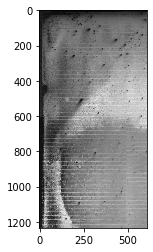

In [15]:
plt.imshow(test_photo)

In [16]:
test_photo.shape

(1234, 608, 4)

In [17]:
res = cv2.resize(test_photo, dsize=(608, 1216), interpolation=cv2.INTER_CUBIC)

In [18]:
res.shape

(1216, 608, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


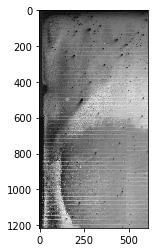

In [19]:
plt.imshow(res)

In [20]:
model1.predict(res)

ValueError: Error when checking : expected input_1 to have 4 dimensions, but got array with shape (1216, 608, 4)

In [54]:
res_list = []
for i in range(4):
    res_list.append(res)

In [65]:
model1.predict(res)

ValueError: Error when checking : expected input_1 to have 4 dimensions, but got array with shape (1216, 608, 4)

In [53]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1216, 608, 4) 0                                            
__________________________________________________________________________________________________
downsampling_0_conv_0 (Conv2D)  (None, 1216, 608, 16 592         input_1[0][0]                    
__________________________________________________________________________________________________
downsampling_0_batchnorm_0 (Bat (None, 1216, 608, 16 64          downsampling_0_conv_0[0][0]      
__________________________________________________________________________________________________
downsampling_0_activation_0 (Ac (None, 1216, 608, 16 0           downsampling_0_batchnorm_0[0][0] 
__________________________________________________________________________________________________
downsampli